## Imports and definitions

In [1]:
import ot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import glob
import itertools
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import time
from tqdm import tqdm

In [2]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)

In [3]:
resolutions = [32, 64, 128, 256, 512]
image_numbers = ['01','02','03','04','05','06','07','08','09','10']

In [4]:
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]
for category in category_names:
    print(category)

CauchyDensity
ClassicImages
GRFmoderate
GRFrough
GRFsmooth
LogGRF
LogitGRF
MicroscopyImages
Shapes
WhiteNoise


## Reading images

In [5]:
image_1_index = 0
image_2_index = 1
resolution = 32

In [6]:
image1 = Image(resolution, category_names[0], image_1_index, full_path)
image2 = Image(resolution, category_names[0], image_2_index, full_path)
cost_matrix = calculate_costs(image1.image.shape)


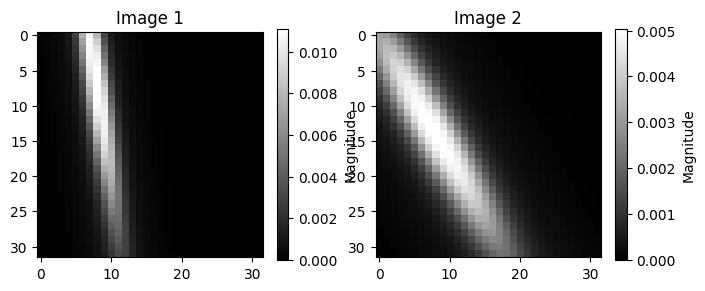

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1.image, "Image 1")
create_subplot(axs[1], image2.image, "Image 2")

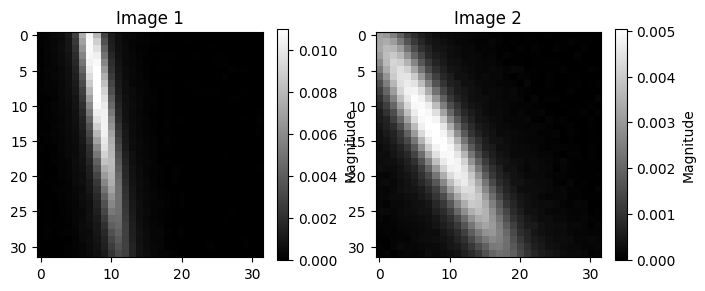

In [11]:
Image.split_image(image1.image, image2.image, noise_param=1e-3)
#plot:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1.image_post, "Image 1")
create_subplot(axs[1], image2.image_post, "Image 2")

In [12]:
w1_dist_original = calculate_and_time_wasserstein(image1.image, image2.image, cost_matrix)[0]
w1_dist_noised = calculate_and_time_wasserstein(image1.image_post, image2.image_post, cost_matrix)[0]
print(f'The Wasserstein distance between the two original images is {w1_dist_original}, and between the two noised images is {w1_dist_noised}')

f_dist_original = calculate_and_time_fourier(image1.image, image2.image)[0]
f_dist_noised = calculate_and_time_fourier(image1.image_post, image2.image_post)[0]
print(f'The Fourier distance between the two original images is {f_dist_original}, and between the two noised images is {f_dist_noised}')

l2_dist_original = calculate_and_time_l2(image1.image, image2.image)[0]
image1.image_noised /= image1.image_noised.sum()
image2.image_noised /= image2.image_noised.sum()
l2_dist_noised = calculate_and_time_l2(image1.image_noised, image2.image_noised)[0]
print(f'The L2 distance between the two original images is {l2_dist_original}, and between the two noised images is {l2_dist_noised}')


The Wasserstein distance between the two original images is 3.85597850768735, and between the two noised images is 3.834851928995547
The Fourier distance between the two original images is 2.3234400541511646, and between the two noised images is 2.306955098203274
The L2 distance between the two original images is 0.06404417932594936, and between the two noised images is 0.06408243964307242


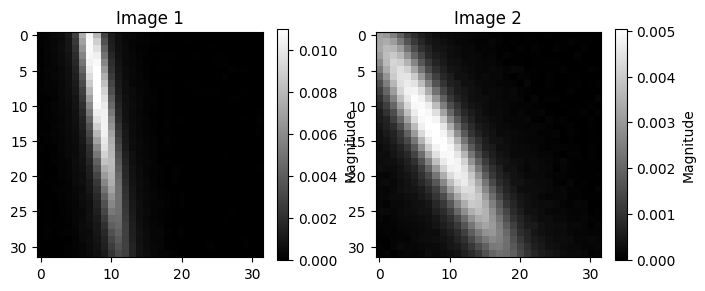

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1_post, "Image 1")
create_subplot(axs[1], image2_post, "Image 2")

## Scaling up, looking into all pairs of images:

In [14]:
df_im_l1 = pd.DataFrame()
category = category_names[0]
res = 32
num_samples = 5
category_dir = os.path.join(full_path, category)
SNR_values = np.logspace(start=5, stop=1, num=31)
noise_values = np.logspace(start=-5, stop=-1, num=31)
pairs = list(itertools.combinations(image_numbers, 2))
df_im_l1 = pd.DataFrame()

In [16]:
for noise_param in tqdm(noise_values):
    SNR = 1 / noise_param
    for image_pair in pairs:
        image1 = Image(res, category, image_pair[0], full_path)
        image2 = Image(res, category, image_pair[1], full_path)

        # Calculate original distances without noise
        w1_dist_original, w1_time_original = calculate_and_time_wasserstein(image1.image, image2.image, cost_matrix)
        f_dist_original, f_time_original = calculate_and_time_fourier(image1.image, image2.image)
        l2_dist_original, l2_time_original = calculate_and_time_l2(image1.image, image2.image)

        results = Image.analyze_image_pair(image1, image2, cost_matrix, num_samples, noise_param)
        w1_dist_noised, f_dist_noised, l2_dist_noised, time_w1, time_f, time_l2 = results

        new_row = {
            'Category': category,
            'image1_index': image_pair[0],
            'image2_index': image_pair[1],
            'Noise': noise_param,
            'SNR': SNR,
            'Resolution': res,
            'Wasserstein Original': w1_dist_original,
            'Wasserstein Noised': w1_dist_noised,
            'Wasserstein Ratio': w1_dist_original / w1_dist_noised,
            'Wasserstein Time': time_w1,
            'Fourier Original': f_dist_original, 
            'Fourier Noised': f_dist_noised,
            'Fourier Ratio': f_dist_original / f_dist_noised,
            'Fourier Time': time_f, 
            'L2 Original': l2_dist_original,
            'L2 Noised': l2_dist_noised,
            'L2 Ratio': l2_dist_original / l2_dist_noised,
            'L2 Time': time_l2}  
        
        df_im_l1 = df_im_l1._append(new_row, ignore_index=True)
df_im_l1.to_csv('results.csv', index=False)


100%|██████████| 31/31 [10:02<00:00, 19.42s/it]


In [17]:
subset = df_im_l1.drop(['Category','image1_index', 'image2_index'], axis=1)
df_grouped = subset.groupby('Noise').mean().reset_index()

In [18]:
df_grouped.tail()

,Noise,SNR,Resolution,Wasserstein Original,Wasserstein Noised,Wasserstein Ratio,Wasserstein Time,Fourier Original,Fourier Noised,Fourier Ratio,Fourier Time,L2 Original,L2 Noised,L2 Ratio,L2 Time
26,0.029286,34.145489,32.0,7.294961,1.394210,5.227923,0.051102,2.772512,0.647252,4.295123,0.001341,0.042054,18.350656,0.013219,0.000070
27,0.039811,25.118864,32.0,7.294961,1.397759,5.205481,0.050867,2.772512,0.644363,4.290567,0.001604,0.042054,9.572010,0.012251,0.000005
28,0.054117,18.478498,32.0,7.294961,1.380975,5.291934,0.050908,2.772512,0.644997,4.295720,0.001247,0.042054,8.292052,0.011436,0.000000
29,0.073564,13.593564,32.0,7.294961,1.392964,5.319314,0.050499,2.772512,0.644945,4.333793,0.001704,0.042054,6.785888,0.009767,0.000070
30,0.100000,10.000000,32.0,7.294961,1.384038,5.272763,0.050319,2.772512,0.637360,4.348960,0.001527,0.042054,7.642366,0.009982,0.000024


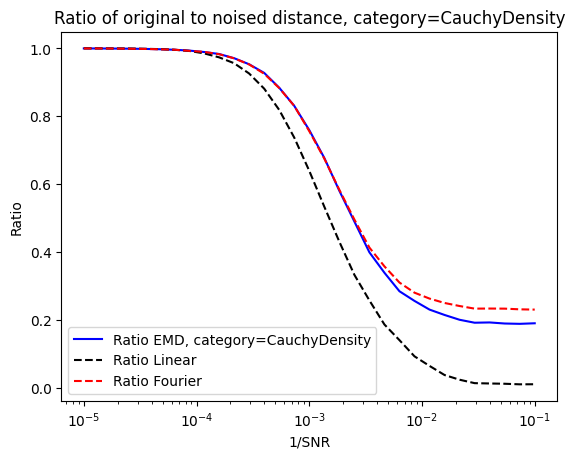

In [19]:
plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Wasserstein Ratio'], label=f'Ratio EMD, category={category}', color='blue')
plt.plot(1/df_grouped['SNR'], df_grouped['L2 Ratio'], label='Ratio Linear', color='black', linestyle='--')
plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

plt.xscale('log')
plt.title(f'Ratio of original to noised distance, category={category}')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.show()

MemoryError: Unable to allocate 512. GiB for an array with shape (262144, 262144, 2) and data type int32

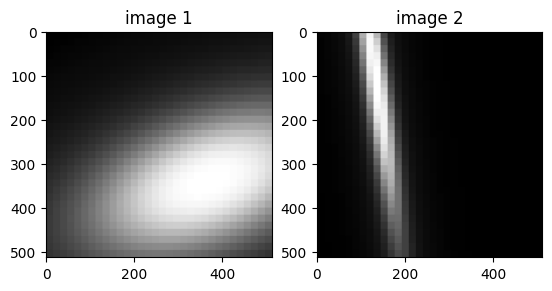

In [38]:
for noise_param in tqdm(noise_values):
    SNR = 1 / noise_param
    for image_pair in pairs:
        image1 = Image(res, category, image_pair[0], full_path)
        image2 = Image(res, category, image_pair[1], full_path)

        # TODO : Add up all the noise results into one function.
        w1_dist_original = ot.emd2(image1.image.flatten(), image2.image.flatten(), cost_matrix)
        f_dist_original = Fourier1(image1.image, image2.image)
        l2_dist_original = np.linalg.norm(image1.image - image2.image) 
        w1_dists_noised = []
        times_w1 = []
        f_dists_noised = []
        times_f = []
        l2_dists_noised = []
        times_l2 = []

        for i in range(num_samples):
            # TODO : Make the processing a function like perform_noise_and_transport analysis.
            _ = image1.split_image(noise_param=noise_param)
            _ = image2.split_image(noise_param=noise_param)
            image1_post = image1.positive + image2.negative
            image2_post = image2.positive + image1.negative
            image1_post = image1_post / np.sum(image1_post)
            image2_post = image2_post / np.sum(image2_post)
            image1_noised_normalized = image1.image_noised / np.sum(image1.image_noised)
            image2_noised_normalized = image2.image_noised / np.sum(image2.image_noised)

            time_start = time.time()
            w1_dists_noised.append(ot.emd2(image1_post.flatten(), image2_post.flatten(), cost_matrix))
            times_w1.append(time.time() - time_start)

            time_start = time.time()
            f_dists_noised.append(Fourier1(image1_post, image2_post))
            times_f.append(time.time() - time_start)
            
            time_start = time.time()
            l2_dists_noised.append(np.linalg.norm(image1_noised_normalized - image2_noised_normalized))
            times_l2.append(time.time() - time_start)

        w1_dist_noised = np.mean(w1_dists_noised)
        f_dist_noised = np.mean(f_dists_noised)
        l2_dist_noised = np.mean(l2_dists_noised)

        time_w1 = np.mean(times_w1)
        time_f = np.mean(times_f)
        time_l2 = np.mean(times_l2)

        new_row = {'Category': category,
                   'image1_index': image_pair[0],
                   'image2_index': image_pair[1],
                   'Noise': noise_param,
                   'SNR': SNR,
                   'Resolution': res,
                   'Wasserstein Original': w1_dist_original,
                   'Wasserstein Noised': w1_dist_noised,
                   'Wasserstein Ratio': w1_dist_original / w1_dist_noised,
                   'Wasserstein Time': time_w1,
                   'Fourier Original': f_dist_original, 
                   'Fourier Noised': f_dist_noised,
                   'Fourier Ratio': f_dist_original / f_dist_noised,
                   'Fourier Time': time_f, 
                   'L2 Original': l2_dist_original,
                   'L2 Noised': l2_dist_noised,
                   'L2 Ratio': l2_dist_original / l2_dist_noised,
                   'L2 Time': time_l2}   
        df_im_l1 = df_im_l1._append(new_row, ignore_index=True)
df_im_l1.to_csv('results.csv', index=False)
